In [62]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
import copy
import random


In [6]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

C:\Users\raque\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\raque\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [7]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [8]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [10]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

torch.Size([1, 7, 50257])


In [11]:
# 50257 the vocabulary size how many tokens it can generate

In [12]:
# whay is the most likely token 
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()
next_token_id

tensor(13990)

In [13]:
#decoding it
tokenizer.decode(next_token_id)

' fence'

In [14]:
# what were the most likely words:
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[' fence',
 ' edge',
 ' railing',
 ' wall',
 ' table',
 ' tree',
 ' top',
 ' counter',
 ' ground',
 ' side']

In [16]:
next_inputs = {
    "input_ids": torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1, 1))],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim=1
    ),
}

In [17]:
print(next_inputs["input_ids"],
      next_inputs["input_ids"].shape)
print(next_inputs["attention_mask"],
      next_inputs["attention_mask"].shape)

tensor([[  464,  2068,  7586, 21831, 11687,   625,   262, 13990]]) torch.Size([1, 8])
tensor([[1, 1, 1, 1, 1, 1, 1, 1]]) torch.Size([1, 8])


In [18]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id

In [19]:
generated_tokens = []
next_inputs = inputs
durations_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
            dim=1),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_s)} s")
print(generated_tokens)

0.47855138778686523 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


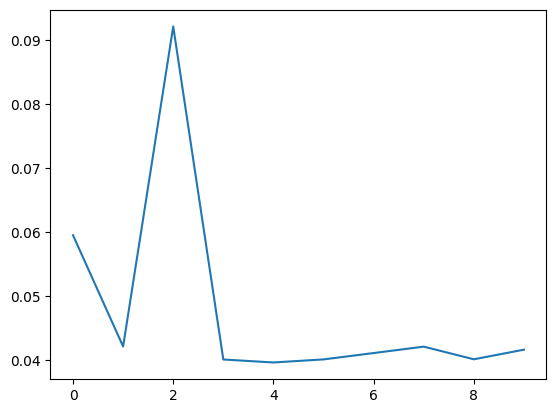

In [20]:
plt.plot(durations_s)
plt.show()

In [21]:
# KV-caching is a technique to speed up token generation by storing some of the tensors in the attention head for use in subsequent generation steps
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

In [22]:
generated_tokens = []
next_inputs = inputs
durations_cached_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
        "past_key_values": past_key_values,
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

0.3604891300201416 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


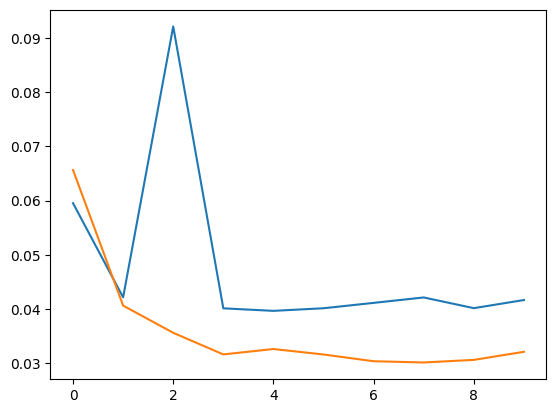

In [23]:
plt.plot(durations_s)
plt.plot(durations_cached_s)
plt.show()

In [25]:
def generate(inputs, max_tokens):
    generated_tokens = []
    next_inputs = inputs
    for _ in range(max_tokens):
        next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1
            ),
            "past_key_values": past_key_values,
        }

        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens)


tokens = generate(inputs, max_tokens=10)
print(tokens)

 fence and ran to the other side of the fence


In [28]:
# ading padding tokes to the model to prepare batrches of prompts:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

In [29]:
# pad on the left so we can append new tokens on the right
# chosing left or right will depend whether we are doing training or inferance and the model
# for inferance this should go on the left since more tokes will be generated on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [30]:
# multiple prompts of varying lengths to send
# to the model at once
# Add padding so that all prompts have the same number of tokens as the longest prompt
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token
# will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

In [31]:
print("input_ids:", inputs["input_ids"])
print("shape:", inputs["input_ids"].shape)

input_ids: tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256,   464,  6290,   287,  8602,  8953],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]])
shape: torch.Size([3, 7])


In [ ]:
# shorter sequences have the 50256 wich os the padding

In [32]:
print("attention_mask:", inputs["attention_mask"])
print("shape:", inputs["attention_mask"].shape)

attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])
shape: torch.Size([3, 7])


In [33]:
# Add position ids to track original order of tokens in each prompt
# Padding tokens are set to 1 and then first real token starts with position 0

In [34]:
# position_ids tell the transformer the ordinal position
# of each token in the input sequence
# for single input inference, this is just [0 .. n]
# for n tokens, but for batch inference,
# we need to 0 out the padding tokens at the start of the sequence
attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)

tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 0, 1, 2, 3, 4],
        [1, 1, 1, 0, 1, 2, 3]])

In [36]:

with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)
logits = outputs.logits

In [38]:
last_logits = logits[:, -1, :] 
next_token_ids = last_logits.argmax(dim=1) 
print(next_token_ids)

tensor([13990,   319,   307])


In [46]:
next_tokens = tokenizer.batch_decode(next_token_ids)
next_tokens

[' fence', ' on', ' be']

In [39]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values

In [40]:
def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1)),  
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [41]:
generated_tokens = generate_batch(inputs, max_tokens=10)

In [42]:
for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence

The rain in Spain falls  on the first day of the month, and the

What comes up must  be a good idea.

"I think



In [43]:
# constants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(8)]
for batch_size in batch_sizes:
    print(f"bs= {batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(
        batch_prompts, padding=True, return_tensors="pt"
    )
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print("duration", duration_s)
    print("throughput", throughput)
    print("avg latency", avg_latency)    
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

bs= 1
duration 0.3340027332305908
throughput 29.939874752749823
avg latency 0.03340027332305908

bs= 2
duration 0.383563756942749
throughput 52.14256988046244
avg latency 0.0383563756942749

bs= 4
duration 0.3822662830352783
throughput 104.63910047831372
avg latency 0.03822662830352783

bs= 8
duration 0.45768308639526367
throughput 174.79343759474324
avg latency 0.04576830863952637

bs= 16
duration 0.533837080001831
throughput 299.7169098846622
avg latency 0.053383708000183105

bs= 32
duration 0.6851933002471924
throughput 467.0214958093663
avg latency 0.06851933002471924

bs= 64
duration 1.033599853515625
throughput 619.1951341935103
avg latency 0.1033599853515625

bs= 128
duration 1.88118577003479
throughput 680.4219021794579
avg latency 0.188118577003479



In [44]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

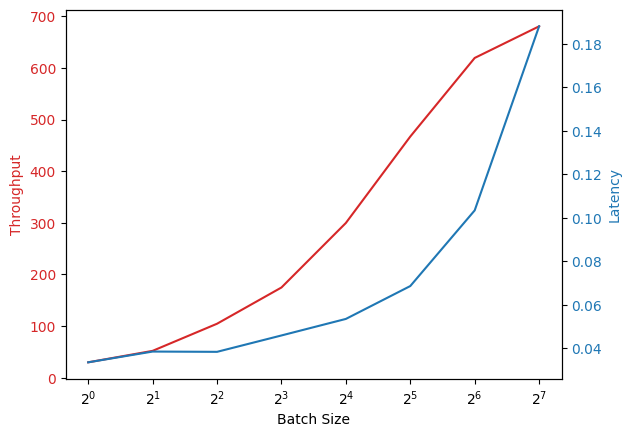

In [45]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)

In [51]:
# seed the random number generator so our results are deterministic
import random
random.seed(42)

# constants
queue_size = 32
batch_size = 8

# requests waiting to be processed
# requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]

In [52]:
request_queue[:8]

[('The quick brown fox jumped over the', 100),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10)]

In [53]:
batches = [
    request_queue[i:i + batch_size]
    for i in range(0, len(request_queue), batch_size)
]

In [54]:
len(batches)

4

In [55]:
batches[0]

[('The quick brown fox jumped over the', 100),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10)]

In [56]:
# generate tokens for all batches and record duration
t0 = time.time()
with tqdm(total=len(batches), desc=f"bs={batch_size}") as pbar:
    for i, batch in enumerate(batches):
        # to accommodate all the requests with our 
        # current implementation, we take the max of
        # all the tokens to generate among the requests
        batch_max_tokens = [b[1] for b in batch]
        max_tokens = max(batch_max_tokens)
        pbar.set_postfix({'max_tokens': max_tokens})
        
        batch_prompts = [b[0] for b in batch]
        inputs = tokenizer(
            batch_prompts, padding=True, return_tensors="pt")
        generate_batch(inputs, max_tokens=max_tokens)
        
        pbar.update(1)

duration_s = time.time() - t0
print("duration", duration_s)

bs=8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.93s/it, max_tokens=100]

duration 19.712871313095093


In [57]:
# This time, rather than processing each batch to completion, you will use continuous batching to dynamically swap in and out inputs from the queue.

In [64]:
## helper functions
def get_next_inputs(batch, next_token_ids, past_key_values, next_tokens):
    return {
        # '-1' here means the remaining elements for this dim
        "input_ids": next_token_ids.reshape((-1, 1)),
        # increment last, discard the rest
        "position_ids": batch["position_ids"][:, -1].unsqueeze(-1) + 1,
        # concatenate vector of 1's with shape [batch_size]
        "attention_mask": torch.cat([
            batch["attention_mask"],
            torch.ones((next_token_ids.shape[0], 1)),  
        ], dim=1),
        "past_key_values": past_key_values,
        "responses": [
            r1 + r2 for r1, r2 
            in zip(batch["responses"], next_tokens)],
        "tokens_remaining": [
            v - 1 for v in batch["tokens_remaining"]],
    }


def init_batch(requests):
    prompts = [r[0] for r in requests]
    inputs = tokenizer(prompts, padding=True, return_tensors="pt")
    
    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)
    
    return {
        "position_ids": position_ids,
        "responses": copy.copy(prompts),
        "tokens_remaining": [r[1] for r in requests],
        **inputs
    }


def generate_next_token(batch):
    inputs = copy.copy(batch)
    inputs.pop("responses")
    inputs.pop("tokens_remaining")
    
    next_token_ids, past_key_values = \
        generate_batch_tokens_with_past(inputs)
    next_tokens = tokenizer.batch_decode(next_token_ids)
    return get_next_inputs(
        batch, next_token_ids, past_key_values, next_tokens)


def merge_batches(batch1, batch2):
    # first find the max sequence length of the two batches
    # this can be obtained from the second dimension 
    # of the attention mask
    attn_mask1 = batch1["attention_mask"]
    attn_mask2 = batch2["attention_mask"]
    max_seq_len = max(attn_mask1.shape[1], attn_mask2.shape[1])
    
    # pad each mask (on the left) to the max sequence length
    # attention mask uses 0 for padding
    padding1 = max_seq_len - attn_mask1.shape[1]
    padding2 = max_seq_len - attn_mask2.shape[1]
    attn_mask1 = F.pad(attn_mask1, (padding1, 0), "constant", 0)
    attn_mask2 = F.pad(attn_mask2, (padding2, 0), "constant", 0)
    
    # because we only append batches post decoding, 
    # we don't need to pad input_ids
    # or position_ids. these are always length 1 
    # in the sequence dimension
    # however, we do need to pad the 
    # past_key_values, which have shape:
    # [batch_size, num_heads, sequence_length, head_dim]
    past_kv1 = batch1["past_key_values"]
    past_kv2 = batch2["past_key_values"]
    
    padded_kv1 = []
    for i in range(len(past_kv1)):
        k, v = past_kv1[i]
        k = F.pad(k, (0, 0, padding1, 0), "constant", 0)
        v = F.pad(v, (0, 0, padding1, 0), "constant", 0)     
        padded_kv1.append((k, v))
    
    padded_kv2 = []
    for i in range(len(past_kv2)):
        k, v = past_kv2[i]
        k = F.pad(k, (0, 0, padding2, 0), "constant", 0)
        v = F.pad(v, (0, 0, padding2, 0), "constant", 0)     
        padded_kv2.append((k, v))
        
    # now that everything has been padded to have
    # consistent shapes, let's merge
    input_ids = torch.concat(
        [batch1["input_ids"], batch2["input_ids"]], dim=0)
    position_ids = torch.concat(
        [batch1["position_ids"], batch2["position_ids"]], dim=0) 
    attn_mask = torch.concat([attn_mask1, attn_mask2], dim=0)
    
    past_kv = []
    for i in range(len(padded_kv1)):
        k1, v1 = padded_kv1[i]
        k2, v2 = padded_kv2[i]
        k = torch.concat([k1, k2], dim=0)
        v = torch.concat([v1, v2], dim=0)
        past_kv.append((k, v))
    
    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attn_mask,
        "past_key_values": past_kv,
        "responses": batch1["responses"] + batch2["responses"],
        "tokens_remaining": batch1["tokens_remaining"] + batch2["tokens_remaining"],
    }


def filter_batch(batch):
    # mark all rows with 0 tokens remaining for removal
    remove_indices = []
    for i, tokens_remaining in enumerate(batch["tokens_remaining"]):
        if tokens_remaining <= 0:
            remove_indices.append(i)
    
    # first, define a mask used to subselect the indices to keep
    # from each tensor, given the indices to remove
    batch_size = batch["input_ids"].size(0)
    mask = torch.ones(batch_size, dtype=torch.bool)
    mask[remove_indices] = False

    # index into the tensors using the mask to remove rows
    input_ids = batch["input_ids"][mask]
    position_ids = batch["position_ids"][mask]
    attention_mask = batch["attention_mask"][mask]
    responses = [
        r 
        for i, r in enumerate(batch["responses"])
        if i not in remove_indices
    ]
    tokens_remaining = [
        v 
        for i, v in enumerate(batch["tokens_remaining"])
        if i not in remove_indices
    ]

    past_key_values = batch["past_key_values"]
    new_past_key_values = []
    for i in range(len(past_key_values)):
        k, v = past_key_values[i]
        k = k[mask]
        v = v[mask]
        new_past_key_values.append((k, v))
    past_key_values = new_past_key_values
    
    if input_ids.size(0) > 0:
        # next, as an optimization to avoid wasting 
        # compute cycles on padding tokens,
        # we will left truncate the attention_mask 
        # and past_key_values to the longest
        # remaining sequence length
        # we obtain the longest sequence length by 
        # looking for the min first non-zero index
        # of the attention mask
        # cumprod ensures we stop accumulating when we see a 1
        zero_mask = attention_mask == 0
        cumprod = zero_mask.cumprod(dim=1)  
        leading_zeros_count = cumprod.sum(dim=1)
        min_leading_zeros = torch.min(leading_zeros_count)
        truncation_offset = min_leading_zeros.item()

        # do the trunction
        attention_mask = attention_mask[:, truncation_offset:]
        past_key_values = past_key_values
        new_past_key_values = []
        for i in range(len(past_key_values)):
            k, v = past_key_values[i]
            k = k[:, :, truncation_offset:, :]
            v = v[:, :, truncation_offset:, :]
            new_past_key_values.append((k, v))
        past_key_values = new_past_key_values
    
    # return the new batch
    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attention_mask,
        "past_key_values": past_key_values,
        "responses": responses,
        "tokens_remaining": tokens_remaining,
    }, remove_indices


def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values




In [65]:
# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 32
batch_size = 8

# requests waiting to be processed
# this time requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]

t0 = time.time()
with tqdm(total=len(request_queue), desc=f"bs={batch_size}") as pbar:
    # first, let's seed the initial cached_batch
    # with the first `batch_size` inputs
    # and run the initial prefill step
    batch = init_batch(request_queue[:batch_size])
    cached_batch = generate_next_token(batch)
    request_queue = request_queue[batch_size:]

    # continue until both the request queue is 
    # fully drained and every input
    # within the cached_batch has completed generation
    while (
        len(request_queue) > 0 or
        cached_batch["input_ids"].size(0) > 0
    ):
        batch_capacity = (
            batch_size - cached_batch["input_ids"].size(0)
        )
        if batch_capacity > 0 and len(request_queue) > 0:
            # prefill
            new_batch = init_batch(request_queue[:batch_capacity])
            new_batch = generate_next_token(new_batch)
            request_queue = request_queue[batch_capacity:]

            # merge
            cached_batch = merge_batches(cached_batch, new_batch)

        # decode
        cached_batch = generate_next_token(cached_batch)

        # remove any inputs that have finished generation
        cached_batch, removed_indices = filter_batch(cached_batch)
        pbar.update(len(removed_indices))

duration_s = time.time() - t0
print("duration", duration_s)

bs=8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.97it/s]

duration 6.444674968719482
